In [1]:
import warnings
warnings.filterwarnings("ignore") 

from arch import arch_model
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scikeras.wrappers import KerasRegressor
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Loading UK inflation rates

In [2]:
# Reading Inflation data csv file
file_path = "Inflation_data.csv"

raw = pd.read_csv(
    file_path,
    header = None,
    usecols = [0, 1],                    # only the first two columns
    names = ["label", "Inflation_Rate"], # explicit names
    dtype = {"label": str}
)

# basic cleanup
raw["label"] = raw["label"].astype(str).str.strip()
raw["Inflation_Rate"] = pd.to_numeric(raw["Inflation_Rate"], errors = "coerce")

# drop rows that are entirely empty or notes
raw = raw.dropna(how = "all")
raw = raw[~raw["label"].str.contains("important", case = False, na = False)]

# Keeping monthly rows only: YYYY MON 
MONTHS = "JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC"
is_monthly = raw["label"].str.fullmatch(rf"\d{{4}}\s+({MONTHS})", na = False)

monthly = raw.loc[is_monthly].copy()

# Parsing to datetime and clean
monthly["Date"] = pd.to_datetime(monthly["label"], format= "%Y %b", errors = "coerce")
monthly = monthly.dropna(subset=["Date", "Inflation_Rate"]).sort_values("Date")


# Saving clean monthly file
monthly[["Date", "Inflation_Rate"]].to_csv("UK_Inflation_Monthly.csv", index=False)
monthly[['Date', 'Inflation_Rate']]

,Date,Inflation_Rate
190,1989-01-01,5.7
191,1989-02-01,5.8
192,1989-03-01,5.9
193,1989-04-01,5.6
194,1989-05-01,5.9
...,...,...
624,2025-03-01,3.4
625,2025-04-01,4.1
626,2025-05-01,4.0
627,2025-06-01,4.1


# Loading cryptocurrency data

In [3]:
# Load the CSV file
btc_data = pd.read_csv('BTC_GBP_Historical_Data.csv', low_memory = False)

# Check for missing values
print("\nMissing values before cleaning:")
print(btc_data.isnull().sum())

# Drop rows with invalid dates
btc_data = btc_data.dropna(subset = ['Date']).reset_index(drop = True)

# Recheck missing values
print("\nMissing values after dropping invalid dates:")
print(btc_data.isnull().sum())


# Define numeric columns
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Clean numeric columns
for col in numeric_cols:
    btc_data[col] = (
        btc_data[col].astype(str)
                     .str.replace(',', '', regex = True)
                     .replace('', 'NaN')
                     .astype(float)
    )

# Recheck missing values after cleaning
print("\nMissing values after cleaning numeric columns:")
print(btc_data.isnull().sum())

# Ensure all numeric columns are floats
btc_data[numeric_cols] = btc_data[numeric_cols].apply(pd.to_numeric, errors = 'coerce')

# Save cleaned data
btc_data.to_csv('BTC_GBP_Cleaned.csv', index = False)
btc_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]


Missing values before cleaning:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Missing values after dropping invalid dates:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Missing values after cleaning numeric columns:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


,Open,High,Low,Close,Adj Close,Volume
0,88264.09,91277.23,88140.91,89253.88,89253.88,1.353493e+11
1,86999.65,88340.84,86876.10,88264.33,88264.33,3.632433e+10
2,87086.71,87583.21,86662.43,87001.89,87001.89,3.372687e+10
3,85407.86,87735.09,85031.73,87076.55,87076.55,6.441129e+10
4,81871.49,85883.07,81640.85,85408.57,85408.57,7.062566e+10
...,...,...,...,...,...,...
1822,7287.81,7319.61,7239.77,7306.56,7306.56,1.029192e+10
1823,7280.76,7345.89,7242.31,7288.64,7288.64,9.750449e+09
1824,7271.21,7319.80,7234.90,7280.92,7280.92,1.109441e+10
1825,7301.02,7324.39,7254.01,7271.54,7271.54,1.251225e+10


# Merging two datasets

In [4]:
# Load BTC-GBP data
btc_cleaned = pd.read_csv('BTC_GBP_Cleaned.csv')
btc_cleaned['Date'] = pd.to_datetime(btc_cleaned['Date'])
btc_cleaned = btc_cleaned.sort_values(by = 'Date').reset_index(drop = True)

# Load inflation data
inflation_cleaned = pd.read_csv('UK_Inflation_Monthly.csv')
inflation_cleaned['Date'] = pd.to_datetime(inflation_cleaned['Date'], errors = 'coerce')
inflation_cleaned = inflation_cleaned.dropna(subset = ['Date']).sort_values(by = 'Date').reset_index(drop = True)

# Merge using asof
merged_data = pd.merge_asof(btc_cleaned, inflation_cleaned[['Date', 'Inflation_Rate']], on = 'Date')

# Forward fill inflation rate to cover all days in a month
merged_data['Inflation_Rate'] = merged_data['Inflation_Rate'].ffill()


# Save and display final dataset
merged_data.to_csv('BTC_GBP_and_UK_Inflation.csv', index = False)
print("\n Merged dataset saved as 'BTC_GBP_and_UK_Inflation.csv'")
print(" Final Merged Dataset:")
merged_data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Inflation_Rate']]


 Merged dataset saved as 'BTC_GBP_and_UK_Inflation.csv'
 Final Merged Dataset:


,Date,Open,High,Low,Close,Adj Close,Volume,Inflation_Rate
0,2020-07-15,7353.64,7376.85,7288.57,7301.70,7301.70,1.258517e+10,1.1
1,2020-07-16,7301.02,7324.39,7254.01,7271.54,7271.54,1.251225e+10,1.1
2,2020-07-17,7271.21,7319.80,7234.90,7280.92,7280.92,1.109441e+10,1.1
3,2020-07-18,7280.76,7345.89,7242.31,7288.64,7288.64,9.750449e+09,1.1
4,2020-07-19,7287.81,7319.61,7239.77,7306.56,7306.56,1.029192e+10,1.1
...,...,...,...,...,...,...,...,...
1822,2025-07-11,81871.49,85883.07,81640.85,85408.57,85408.57,7.062566e+10,4.2
1823,2025-07-12,85407.86,87735.09,85031.73,87076.55,87076.55,6.441129e+10,4.2
1824,2025-07-13,87086.71,87583.21,86662.43,87001.89,87001.89,3.372687e+10,4.2
1825,2025-07-14,86999.65,88340.84,86876.10,88264.33,88264.33,3.632433e+10,4.2


# Exploratory data analysis

In [5]:
# Load merged dataset
merged_data = pd.read_csv('BTC_GBP_and_UK_Inflation.csv')

# Ensure 'Date' is in datetime format
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Set Date as index
merged_data.set_index('Date', inplace = True)

# Basic information and summary stats
print(" Dataset Info:")
print(merged_data.info())

print("\n Summary Statistics:")
print(merged_data.describe())

# Check date range
print("\n Date range of BTC prices:")
print(f"Start: {merged_data.index.min()}")
print(f"End: {merged_data.index.max()}")

# Check for missing values
print("\n Missing Values:")
print(merged_data.isnull().sum())

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-07-15 to 2025-07-15
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            1827 non-null   float64
 1   High            1827 non-null   float64
 2   Low             1827 non-null   float64
 3   Close           1827 non-null   float64
 4   Adj Close       1827 non-null   float64
 5   Volume          1827 non-null   float64
 6   Inflation_Rate  1827 non-null   float64
dtypes: float64(7)
memory usage: 114.2 KB
None

 Summary Statistics:
               Open          High           Low         Close     Adj Close  \
count   1827.000000   1827.000000   1827.000000   1827.000000   1827.000000   
mean   35287.150454  36009.382567  34545.574286  35329.530279  35329.530279   
std    19864.208478  20220.159120  19512.973788  19893.628044  19893.628044   
min     7236.170000   7319.610000   7219.460000   7237.520000   7237.52

# Visualizing Trends

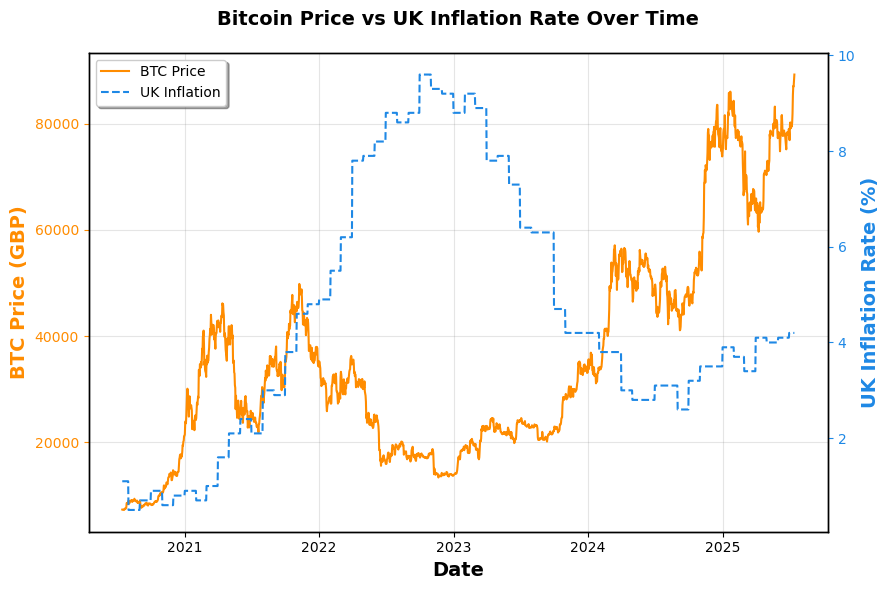

In [6]:
def plot_bitcoin_inflation_comparison(merged_data, figsize = (9, 6)):
    """
    Plotting a line graph comparing Bitcoin prices and UK inflation rates over time.
    
    """
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize = figsize)
    
    # Set white background for clean appearance
    fig.patch.set_facecolor('white')
    ax1.set_facecolor('white')
    
    # Adding black border around chart for definition
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    # Plot Bitcoin price on primary y-axis (left) with thinner line
    btc_color = '#FF8C00'  #  Orange
    ax1.set_xlabel('Date', fontsize = 14, fontweight = 'bold')
    ax1.set_ylabel('BTC Price (GBP)', fontsize = 14, color = btc_color, fontweight = 'bold')
    ax1.plot(merged_data.index, merged_data['Close'], color = btc_color, linewidth = 1.5, label = 'BTC Price')
    
    # Format Bitcoin y-axis with matching orange ticks
    ax1.tick_params(axis = 'y', labelcolor = btc_color, colors = btc_color)
    ax1.grid(True, alpha = 0.2, color = 'gray', linestyle = '-')
    
    # Create secondary y-axis for inflation rate
    ax2 = ax1.twinx()
    ax2.set_facecolor('white')
    
    # Add border to secondary axis
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    # Plot UK inflation rate on secondary y-axis (right) with thinner line
    inflation_color = '#1E88E5'  # Softer blue for inflation data
    ax2.set_ylabel('UK Inflation Rate (%)', fontsize = 14, color = inflation_color, fontweight = 'bold')
    ax2.plot(merged_data.index, merged_data['Inflation_Rate'], color = inflation_color, 
             linewidth = 1.5, linestyle = '--', label = 'UK Inflation')
    
    # Format inflation y-axis with matching blue ticks
    ax2.tick_params(axis = 'y', labelcolor = inflation_color, colors = inflation_color)
    
    # Use x-axis to show only years for cleaner appearance
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    
    # Add descriptive title
    plt.title('Bitcoin Price vs UK Inflation Rate Over Time', fontsize = 14, fontweight = 'bold', pad = 20)
    
    # Combine legends from both axes for clear interpretation
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc = 'upper left', fontsize = 10, 
               frameon = True, fancybox = True, shadow = True)
    
    # Display the finalized chart
    plt.tight_layout()
    plt.show()

# Call the function
plot_bitcoin_inflation_comparison(merged_data, figsize = (9, 6))

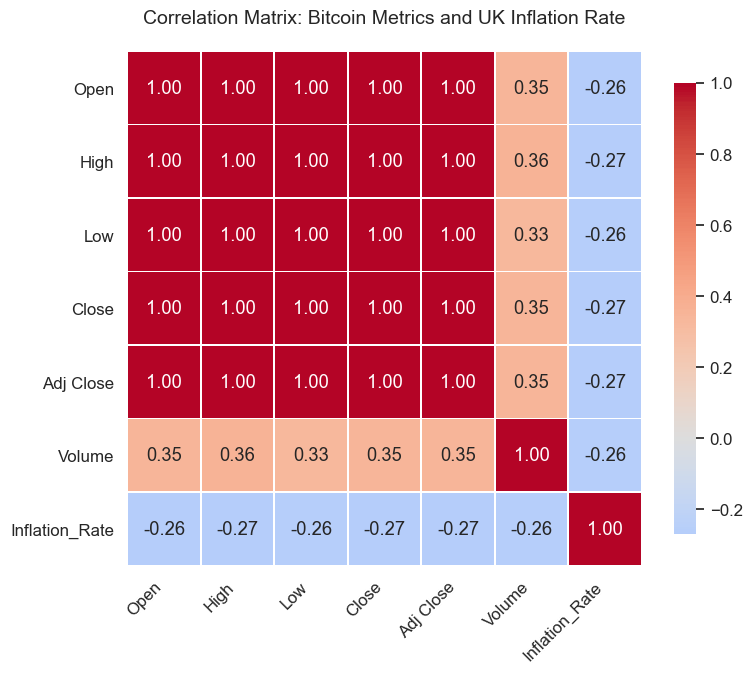

In [7]:
def plot_correlation_matrix(merged_data, figsize=(8, 7)):
    """
    Create a correlation matrix heatmap for Bitcoin metrics and UK inflation rate.
    
    """
    # Setting style
    plt.style.use('default')
    sns.set(font_scale = 1.1)
    
    # Calculate correlation matrix
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Inflation_Rate']
    corr_matrix = merged_data[numeric_cols].corr()
    
    # Set up the matplotlib figure
    plt.figure(figsize = figsize)
    
    # Draw the heatmap without masking
    heatmap = sns.heatmap(
        corr_matrix, 
        annot = True, 
        fmt = '.2f', 
        cmap = 'coolwarm', 
        center = 0, 
        square = True, 
        linewidths = 0.5, 
        cbar_kws = {"shrink": 0.8}
    )
    
    # Rotate the tick labels for better readability
    plt.xticks(rotation = 45, ha = 'right')
    plt.yticks(rotation = 0)
    
    # Add title
    plt.title('Correlation Matrix: Bitcoin Metrics and UK Inflation Rate', fontsize = 14, pad = 20)
    
    # Display output
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(merged_data, figsize = (8, 7))

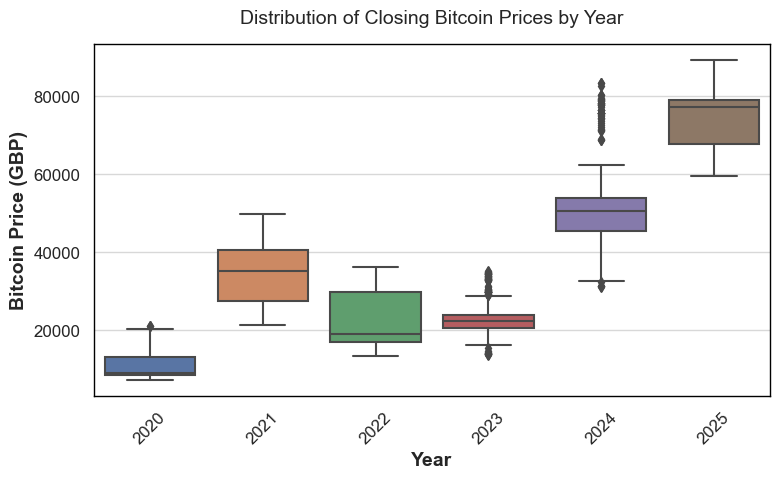

In [8]:
def plot_bitcoin_prices_by_year(merged_data, figsize=(8, 5)):
    """
    Create a box plot showing the distribution of Bitcoin closing prices by year.
    
    """
    # Extract year from the index
    data_with_year = merged_data.copy()
    data_with_year['Year'] = data_with_year.index.year
    
    # Set up the plot with white background
    plt.figure(figsize = figsize)
    plt.rcParams['figure.facecolor'] = 'white'
    
    # Create the box plot
    ax = sns.boxplot(x = 'Year', y = 'Close', data = data_with_year)
    
    # Set white background for the axes
    ax.set_facecolor('white')
    
    # Customize labels and title
    plt.xlabel('Year', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Bitcoin Price (GBP)', fontsize = 14, fontweight = 'bold')
    plt.title('Distribution of Closing Bitcoin Prices by Year', fontsize = 14, pad = 15)
    
    # Format x-axis labels
    plt.xticks(rotation = 45)
    
    # Add grid lines
    plt.grid(True, alpha = 0.3, axis = 'y', color = 'gray', linestyle = '-')
    
    # Add black border to the chart
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    # Display output
    plt.tight_layout()
    plt.show()

plot_bitcoin_prices_by_year(merged_data, figsize = (8, 5))

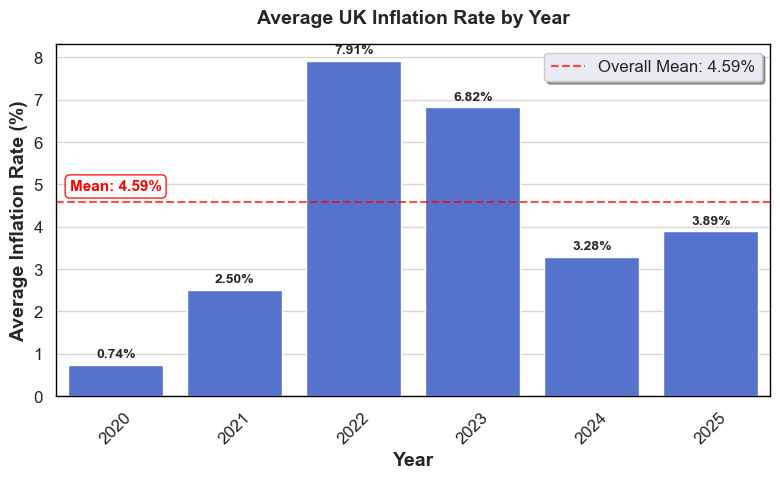

In [9]:
def plot_inflation_by_year(data, figsize=(8, 5)):
    """
    Create a bar chart showing the average UK inflation rate by year with mean statistics.
    """
    # Create a copy to avoid modifying the original data
    data = data.copy()
    
    # Reset index to make Date a column (if it's currently the index)
    if 'Date' not in data.columns:
        data = data.reset_index()
    
    # Convert Date to datetime and extract year
    data['Year'] = pd.to_datetime(data['Date']).dt.year
    
    # Set white background
    plt.figure(figsize=figsize)
    plt.rcParams['figure.facecolor'] = 'white'
    
    # Calculate yearly average inflation
    yearly_inflation = data.groupby('Year')['Inflation_Rate'].mean().reset_index()
    
    # Create bar plot with royal blue color
    ax = sns.barplot(x='Year', y='Inflation_Rate', data=yearly_inflation, color='#4169E1')
    
    # Set white background for the axes
    ax.set_facecolor('white')
    
    # Add value labels on top of each bar
    for i, v in enumerate(yearly_inflation['Inflation_Rate']):
        ax.text(i, v + 0.1, f'{v:.2f}%', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Add horizontal line for overall mean
    overall_mean = data['Inflation_Rate'].mean()
    plt.axhline(y=overall_mean, color='red', linestyle='--', alpha=0.7, 
                label=f'Overall Mean: {overall_mean:.2f}%')
    
    # Add mean annotation 
    plt.text(0, overall_mean + 0.2, f'Mean: {overall_mean:.2f}%', 
             fontsize=11, color='red', ha='center', va='bottom', fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor='red'))
    
    # Customize plot
    plt.xlabel('Year', fontsize=14, fontweight='bold')
    plt.ylabel('Average Inflation Rate (%)', fontsize=14, fontweight='bold')
    plt.title('Average UK Inflation Rate by Year', fontsize=14, fontweight='bold', pad=15)
    plt.xticks(rotation=45)
    
    # Adding legend
    plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    # Add black border and grid
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    # Using gray grid lines for better contrast on white background
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', axis='y')
    
    # Display output
    plt.tight_layout()
    plt.show()


plot_inflation_by_year(merged_data, figsize=(8, 5))

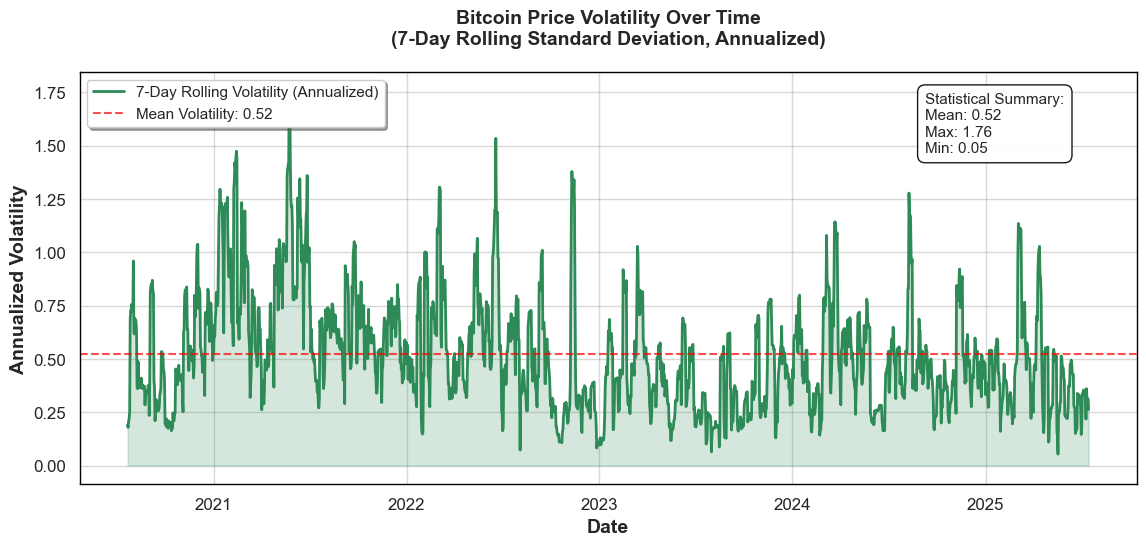

In [10]:
def plot_bitcoin_volatility(data, figsize = (12, 6)):
    """
    Create a line chart showing Bitcoin's 7-day rolling volatility over time.
    
    """
    # Calculate daily returns
    data = data.copy()
    data['Daily_Returns'] = data['Close'].pct_change()
    
    # Calculate 7-day rolling volatility (annualized)
    data['Rolling_Volatility'] = data['Daily_Returns'].rolling(window = 7).std() * np.sqrt(365)
    
    # Create the plot with white background
    plt.figure(figsize = figsize)
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    
    # Plot with enhanced styling
    plt.plot(
        data.index,
        data['Rolling_Volatility'],
        label = '7-Day Rolling Volatility (Annualized)',
        color = '#2E8B57',  # green
        linewidth = 2
    )
    
    # Adding fill under the curve for better visual impact
    plt.fill_between(
        data.index,
        data['Rolling_Volatility'],
        alpha = 0.2,
        color = '#2E8B57'
    )
    
    # Formatting
    plt.title('Bitcoin Price Volatility Over Time\n(7-Day Rolling Standard Deviation, Annualized)', 
              fontsize = 14, fontweight = 'bold', pad = 20)
    plt.xlabel('Date', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Annualized Volatility', fontsize = 14, fontweight = 'bold')
    
    # Set white background and add grid
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(True, alpha = 0.3, color = 'gray')
    
    # Improved x-axis formatting for better readability
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Add minor ticks for better reference
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval = 3))
    
    # Horizontal line to show mean volatility for reference
    mean_volatility = data['Rolling_Volatility'].mean()
    plt.axhline(y = mean_volatility, color = 'red', linestyle = '--', alpha = 0.7, 
                label = f'Mean Volatility: {mean_volatility:.2f}')
    
    # Add legend
    plt.legend(fontsize = 11, frameon = True, fancybox = True, shadow = True, loc = 'upper left')
    
    # Statistical summary
    stats_text = f"""Statistical Summary:
Mean: {mean_volatility:.2f}
Max: {data['Rolling_Volatility'].max():.2f}
Min: {data['Rolling_Volatility'].min():.2f}"""
    plt.annotate(stats_text, xy = (0.80, 0.95), xycoords = 'axes fraction',
                 bbox = dict(boxstyle = "round,pad=0.5", facecolor = "white", alpha = 0.9, edgecolor = 'black'),
                 fontsize = 11, va = 'top')
    
    # Add black border to the chart
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    # Display output
    plt.tight_layout(pad=2.0)
    plt.show()

plot_bitcoin_volatility(merged_data, figsize = (12, 6))

# LSTM Model

x_train shape: (1236, 60, 1)
y_train shape: (1236, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________

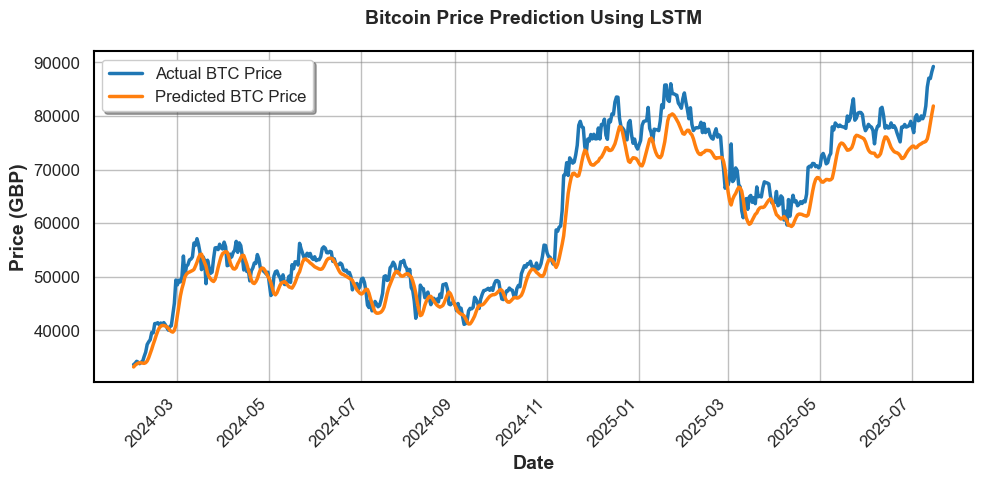

In [11]:
def prepare_forecasting_data(data, sequence_length = 60, train_split = 0.7):
    """
    Preparing data for LSTM forecasting by scaling and creating sequences.
    
    """
    # Selecting feature Close price for forecasting
    price_data = data[['Close']].values
    
    # Scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(price_data)
    
    def create_sequences(data, seq_length):
        x = []
        y = []
        for i in range(seq_length, len(data)):
            x.append(data[i - seq_length:i])
            y.append(data[i])
        return np.array(x), np.array(y)
    
    # Create sequences
    x, y = create_sequences(scaled_data, sequence_length)
    
    # Split into train/test sets
    split_index = int(len(x) * train_split)
    x_train, x_test = x[:split_index], x[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    # Setting dates for the test plot
    test_dates = data.index[split_index + sequence_length:]
    
    print("x_train shape:", x_train.shape)
    print("y_train shape:", y_train.shape)
    
    return x_train, x_test, y_train, y_test, scaler, test_dates


def build_lstm_model(input_shape, units = 100, dropout_rate = 0.2):
    """
    Build and compile an LSTM model for time series forecasting.
    
    """
    model = Sequential()
    model.add(LSTM(units = units, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units = units // 2, return_sequences = False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 1))  # Output layer
    
    # Compiling the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    return model


def train_and_evaluate_model(model, x_train, y_train, x_test, y_test, 
                            epochs = 25, batch_size = 32, validation_split = 0.1):
    """
    Train and evaluate the LSTM model.
    
    """
    # Training the model
    history = model.fit(
        x_train, y_train, 
        epochs = epochs, 
        batch_size = batch_size, 
        validation_split = validation_split, 
        verbose = 1
    )
    
    # Evaluating model
    loss = model.evaluate(x_test, y_test)
    print(f"Test Loss: {loss:.4f}")
    
    return model, history, loss


def make_predictions(model, x_test, y_test, scaler):
    """
    Make predictions using the trained model and return actual and predicted prices.
    
    """
    # Making predictions
    predicted_prices = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)
    actual_prices = scaler.inverse_transform(y_test)
    
    return actual_prices, predicted_prices


def calculate_metrics(actual, predicted):
    """
    Calculate evaluation metrics for the predictions.
    
    """
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return metrics

def plot_predictions(test_dates, actual_prices, predicted_prices):
    """
    Plot actual vs predicted prices with improved styling and layout.
    """
    # Create figure with white background
    plt.figure(figsize = (10,5), facecolor = 'white')
    ax = plt.gca()
    ax.set_facecolor('white')
    
    # Plot data with thicker lines
    plt.plot(test_dates, actual_prices, color = '#1f77b4', linewidth = 2.5, label = 'Actual BTC Price')
    plt.plot(test_dates, predicted_prices, color = '#ff7f0e', linewidth = 2.5, label = 'Predicted BTC Price')
    
    # Set titles and labels with larger fonts
    plt.title('Bitcoin Price Prediction Using LSTM', fontsize = 14, fontweight = 'bold', pad = 20)
    plt.xlabel('Date', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Price (GBP)', fontsize = 14, fontweight = 'bold')
    
    # Add legend with larger font and better positioning
    plt.legend(fontsize = 12, frameon = True, fancybox = True, shadow = True, loc = 'upper left')
    
    # Improve grid
    plt.grid(True, alpha = 0.5, color = 'gray', linestyle = '-')
    
    # Format x-axis dates for better readability
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gcf().autofmt_xdate(rotation=45)  # Rotate date labels
    
    # Add black border to the chart
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    
    # Adjust layout to prevent overlapping
    plt.tight_layout(pad=1.0)
    
    # Show plot
    plt.show()


# Main function to run the entire forecasting pipeline
def run_bitcoin_forecasting(data, sequence_length = 60, train_split = 0.7, 
                           epochs = 25, batch_size = 32):
    """
    Run the complete Bitcoin price forecasting pipeline.
    
    """
    # Prepare data
    x_train, x_test, y_train, y_test, scaler, test_dates = prepare_forecasting_data(
        data, sequence_length, train_split
    )
    
    # Build model
    model = build_lstm_model((x_train.shape[1], 1))
    
    # Display model summary
    model.summary()
    
    # Train and evaluate model
    model, history, test_loss = train_and_evaluate_model(
        model, x_train, y_train, x_test, y_test, epochs, batch_size
    )
    
    # Make predictions
    actual_prices, predicted_prices = make_predictions(model, x_test, y_test, scaler)
    
    # Calculate metrics
    metrics = calculate_metrics(actual_prices, predicted_prices)
    
    # Plot results
    plot_predictions(test_dates, actual_prices, predicted_prices)
    
    return model, history, metrics, actual_prices, predicted_prices

model, history, metrics, actual, predicted = run_bitcoin_forecasting(merged_data)

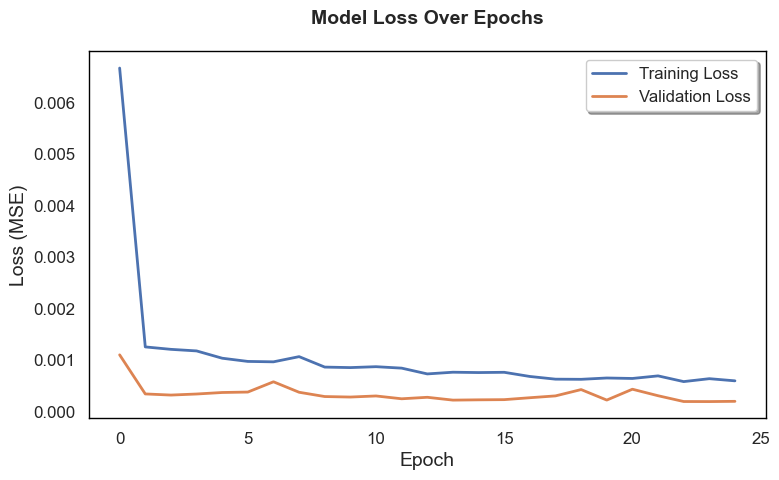

In [12]:
def plot_training_history(history, figsize=(8, 5)):
    """
    Plot training and validation loss over epochs.
    
    """
    # Creating figure with white background
    plt.figure(figsize = figsize)
    plt.rcParams['figure.facecolor'] = 'white'
    
    # Plot training and validation loss
    plt.plot(history.history['loss'], label = 'Training Loss', linewidth = 2)
    plt.plot(history.history['val_loss'], label = 'Validation Loss', linewidth = 2)
    
    # Formatting
    plt.title('Model Loss Over Epochs', fontsize = 14, fontweight = 'bold', pad = 20)
    plt.ylabel('Loss (MSE)', fontsize = 14)
    plt.xlabel('Epoch', fontsize = 14)
    plt.legend(fontsize = 12, frameon = True, fancybox = True, shadow = True)
    plt.grid(True, alpha = 0.3)
    
    # Add black border to the chart
    ax = plt.gca()
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    # Ensure proper layout
    plt.tight_layout()
    plt.show()

plot_training_history(history, figsize = (8, 5))

# Hyperparameter Tuning

Fitting 2 folds for each of 1 candidates, totalling 2 fits

=== GRID SEARCH RESULTS ===
Best parameters found:  {'batch_size': 32, 'epochs': 25, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.001, 'model__units1': 100, 'model__units2': 32}
Best cross-validation score (Negative MSE):  -0.0010410649040321369

Full results for all parameter combinations:
                                              params  mean_test_score  \
0  {'batch_size': 32, 'epochs': 25, 'model__dropo...        -0.001041   

   std_test_score  rank_test_score  
0        0.000343                1  
12/12 [==============================] - 1s 38ms/step
Model Accuracy Metrics:
Mean Squared Error (MSE): 35777225.61
Root Mean Squared Error (RMSE): 5981.41
Mean Absolute Error (MAE): 5227.90
R² Score: 0.8034


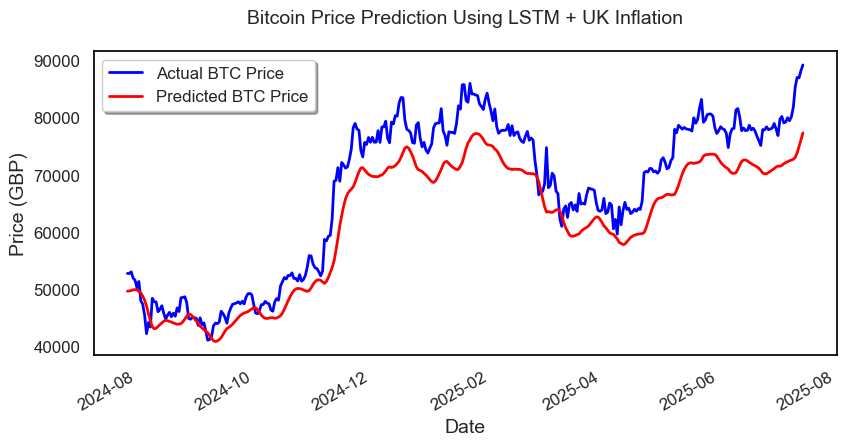

In [13]:
# Load and Prepare Dataset
merged_data = pd.read_csv("BTC_GBP_and_UK_Inflation.csv")
merged_data["Date"] = pd.to_datetime(merged_data["Date"])
merged_data.set_index("Date", inplace = True)

# Selecting features (BTC Close and UK Inflation)
features = ['Close', 'Inflation_Rate']
data = merged_data[features].values

# Min-Max Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Creatinh Sequences for LSTM
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i - seq_length:i])
        y.append(data[i, 0])  # predicting BTC Close
    return np.array(x), np.array(y)

SEQ_LENGTH = 60
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train/Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)

# Define LSTM Model Function for SciKeras
def build_lstm_model(units1 = 64, units2 = 32, dropout_rate = 0.3, learning_rate = 0.001, **kwargs):
    model = Sequential()
    model.add(LSTM(units1, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'mean_squared_error')
    return model

# Wrap with SciKeras
regressor = KerasRegressor(model=build_lstm_model, verbose = 0)

# Hyperparameter grid defined
param_grid = {
    "model__units1": [100],           # Only test one value - 100 is a good starting point
    "model__units2": [32],            # Only test one value - 32 is a good starting point
    "model__dropout_rate": [0.3],     # Only test one value - 0.3 is a good default
    "model__learning_rate": [0.001],  # Only test one value - 0.001 is a good default
    "batch_size": [32],               # Only test one value
    "epochs": [25]                    # Only test one value
}

# Grid Search CV
grid_search = GridSearchCV(
    estimator = regressor,
    param_grid = param_grid,
    cv = 2,
    scoring = "neg_mean_squared_error",
    verbose = 1,
    n_jobs = 1  # safer with Keras on Windows
)

# Fitting model
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_.model_

# After fitting the grid search, print the best parameters and score
print("\n=== GRID SEARCH RESULTS ===")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (Negative MSE): ", grid_search.best_score_)

# (Optional) View the full results for all parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
print("\nFull results for all parameter combinations:")
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# Predict & Re-Scale
y_pred = best_model.predict(x_test).flatten()

# Inverse scale predictions
dummy_pred = np.zeros((len(y_pred), len(features)))
dummy_pred[:, 0] = y_pred
y_pred_actual = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_actual = np.zeros((len(y_test), len(features)))
dummy_actual[:, 0] = y_test
y_test_actual = scaler.inverse_transform(dummy_actual)[:, 0]

# Evaluation Metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print("Model Accuracy Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")


# Plot Predictions vs Actuals
test_dates = merged_data.index[-len(y_test):]

plt.figure(figsize=(9, 5))
  # Add proper styling with grid
ax = plt.axes()
ax.set_facecolor('white')  # Set background color

# Plot data
plt.plot(test_dates, y_test_actual, label = "Actual BTC Price", color = "blue", linewidth = 2)
plt.plot(test_dates, y_pred_actual, label = "Predicted BTC Price", color = "red", linewidth = 2)

# Formatting
plt.title("Bitcoin Price Prediction Using LSTM + UK Inflation", fontsize = 14, pad = 20)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("Price (GBP)", fontsize = 14)
plt.legend(frameon = True, fancybox = True, shadow = True)

# Format x-axis dates
plt.gcf().autofmt_xdate()  # Rotate and align dates
date_format = mdates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval = 2))

# Add proper borders
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.grid(True, alpha = 0.3)
plt.tight_layout(pad = 2.0)
plt.show()

# GARCH Model

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -4555.79
Distribution:                  Normal   AIC:                           9117.58
Method:            Maximum Likelihood   BIC:                           9134.11
                                        No. Observations:                 1826
Date:                Thu, Aug 28 2025   Df Residuals:                     1826
Time:                        02:17:39   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2957      0.136      2.171  2.993e-02 [2.874e-0

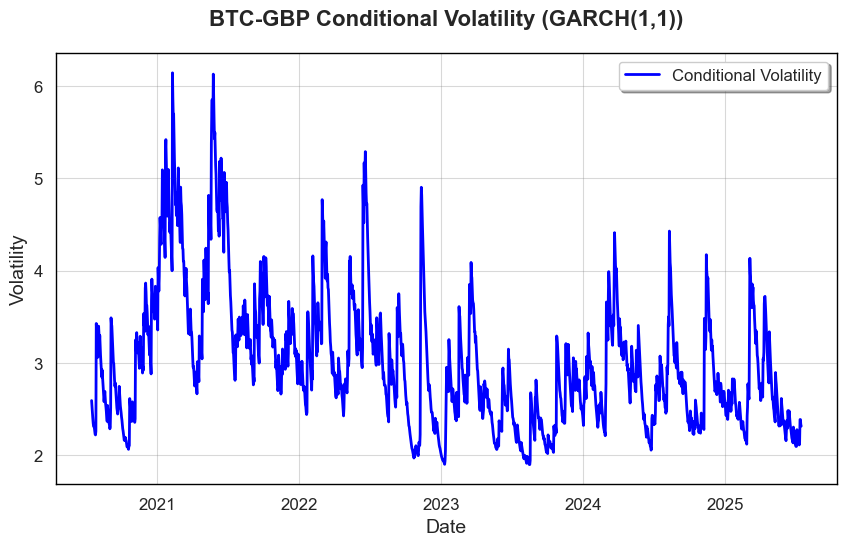

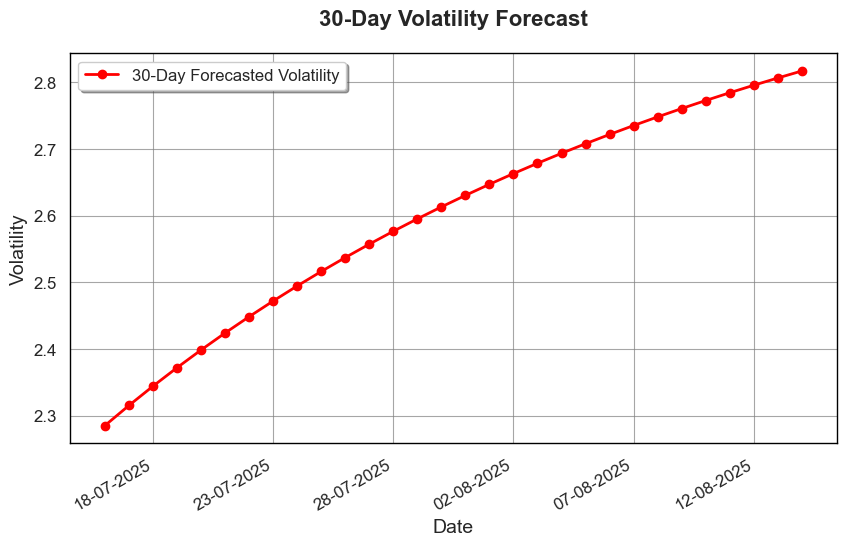

In [17]:
def prepare_btc_data(data):
    """
    Prepare Bitcoin data for GARCH modeling by extracting closing prices and calculating returns.

    """
    # Extract BTC price data
    btc_data = data[['Close']].copy()
    
    # Calculate daily returns
    btc_data['Returns'] = btc_data['Close'].pct_change() * 100  # Convert to percentage
    btc_data.dropna(inplace = True)
    
    return btc_data


def fit_garch_model(returns_data, mean = 'Zero', vol = 'GARCH', p = 1, q = 1, dist = 'Normal'):
    """
    Fit a GARCH model to the returns data.
    
    """
    # Fit GARCH model
    garch_model = arch_model(
        returns_data,
        mean = mean,
        vol = vol,
        p = p,
        q = q,
        dist = dist
    )
    res = garch_model.fit(disp = 'off')
    
    return res


def plot_conditional_volatility(volatility_data, figsize = (9, 6)):
    """
    Plotting conditional volatility from GARCH model results.
    
    """
    plt.figure(figsize = figsize)
    plt.rcParams['figure.facecolor'] = 'white' 
    plt.plot(volatility_data.index, volatility_data, label = 'Conditional Volatility', color = 'blue', linewidth = 2)
    plt.title('BTC-GBP Conditional Volatility (GARCH(1,1))', fontsize = 16, fontweight = 'bold', pad = 20)
    plt.xlabel('Date', fontsize = 14)
    plt.ylabel('Volatility', fontsize = 14)
    plt.legend(fontsize = 12, frameon = True, fancybox = True, shadow = True)
    plt.grid(True, alpha = 0.3, color='gray', linestyle = '-', linewidth = 0.8)
    
    # Add black border to the chart
    ax = plt.gca()
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    plt.tight_layout(pad = 2.0)
    plt.show()


def forecast_and_plot_volatility(model, last_date, horizon = 30, figsize = (9, 6)):
    """
    Forecast future volatility and plot the results.
    
    """
    # Forecasting Future Volatility
    forecasts = model.forecast(horizon = horizon, start = last_date)
    
    # Get the forecasted variance and convert to volatility
    forecast_var = forecasts.variance.iloc[-1].values
    forecast_vol = np.sqrt(forecast_var)
    
    # Create future date range starting from tomorrow
    future_dates = pd.date_range(start = last_date + pd.Timedelta(days = 1), periods = horizon, freq = 'D')
    
    # Create DataFrame for plotting
    forecast_data = pd.DataFrame({
        'Forecasted_Volatility': forecast_vol
    }, index = future_dates)
    
    # Plot forecast
    plt.figure(figsize = figsize)
    plt.rcParams['figure.facecolor'] = 'white'
    
    plt.plot(forecast_data.index, forecast_data['Forecasted_Volatility'], 
             label = f'{horizon}-Day Forecasted Volatility', color = 'red', marker = 'o', linewidth = 2)
    plt.title(f'{horizon}-Day Volatility Forecast', fontsize = 16, fontweight = 'bold', pad = 20)
    plt.xlabel('Date', fontsize = 14)
    plt.ylabel('Volatility', fontsize = 14)
    plt.legend(fontsize = 12, frameon = True, fancybox = True, shadow = True)
    plt.grid(True, color = 'gray', linestyle = '-', alpha = 0.7, linewidth = 0.8)
    
    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 5))
    plt.gcf().autofmt_xdate()
    
    # Add black border to the chart
    ax = plt.gca()
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    plt.tight_layout(pad = 2.0)
    plt.show()
    
    return forecast_data


def run_garch_analysis(data, horizon = 30):
    """
    Run the complete GARCH analysis pipeline for Bitcoin volatility.

    """
    # Prepare data
    btc_data = prepare_btc_data(data)
    
    # Fit GARCH model
    garch_results = fit_garch_model(btc_data['Returns'])
    
    # Print model summary
    print(garch_results.summary())
    
    # Plot conditional volatility
    volatility_data = pd.DataFrame({
        'Conditional_Volatility': garch_results.conditional_volatility
    }, index = btc_data.index)
    
    plot_conditional_volatility(volatility_data['Conditional_Volatility'])
    
    # Forecast and plot future volatility
    forecast_data = forecast_and_plot_volatility(garch_results, btc_data.index[-1], horizon)
    
    return btc_data, garch_results, forecast_data

btc_data, garch_results, forecast = run_garch_analysis(merged_data, horizon = 30)

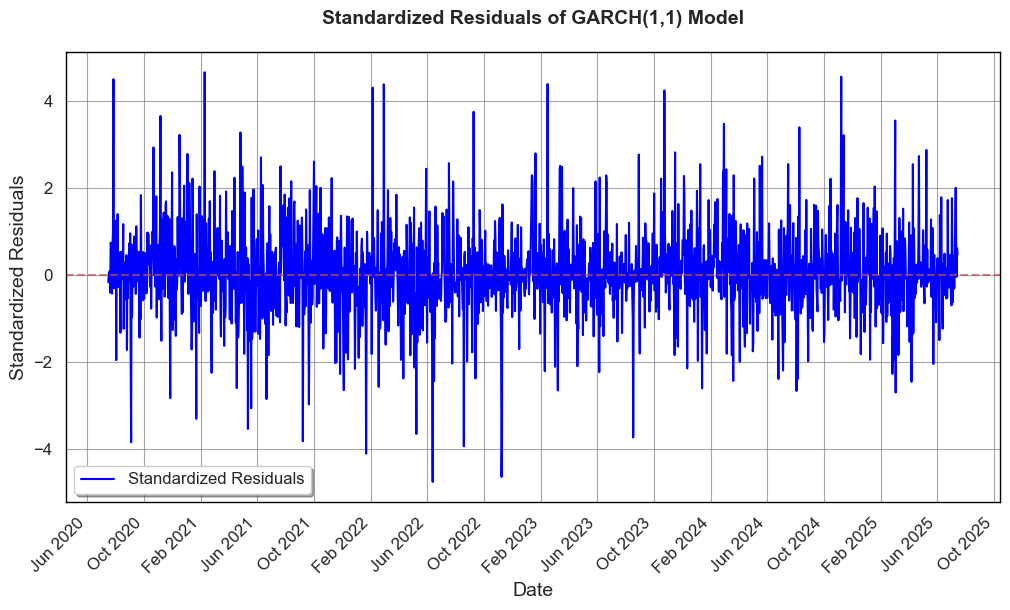

<Figure size 1200x600 with 0 Axes>

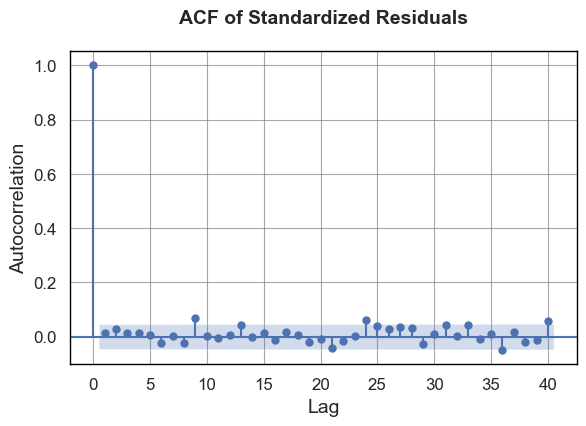

In [19]:
# Calculate standardized residuals
standardized_residuals = garch_results.resid / garch_results.conditional_volatility

# Plot Standardized Residuals
def plot_standardized_residuals(residuals, dates, figsize = (11, 7)):
    """
    Plot standardized residuals from GARCH model with improved date formatting.
    """
    # Create figure with white background
    plt.figure(figsize = figsize)
    plt.rcParams['figure.facecolor'] = 'white'
    
    # Plot standardized residuals
    plt.plot(dates, residuals, label = 'Standardized Residuals', color = 'blue', linewidth = 1.5)
    plt.axhline(y = 0, color = 'r', linestyle='--', alpha = 0.7, linewidth = 1.5)
    
    # Formatting
    plt.title('Standardized Residuals of GARCH(1,1) Model', fontsize = 14, fontweight = 'bold', pad = 20)
    plt.xlabel('Date', fontsize = 14)
    plt.ylabel('Standardized Residuals', fontsize = 14)
    plt.legend(fontsize = 12, frameon=True, fancybox = True, shadow = True)
    
    # Enhanced grid lines
    plt.grid(True, color = 'gray', linestyle = '-', alpha= 0.7, linewidth = 0.8)
    
    # Improved date formatting to reduce congestion
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # "Jan 2020" format
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))   # Show every 4 months
    
    # Rotate date labels
    plt.gcf().autofmt_xdate(rotation = 45, ha = 'right')
    
    # Add black border to the chart
    ax = plt.gca()
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    # Add more padding to accommodate rotated labels
    plt.tight_layout(pad = 3.0)
    plt.show()

# Plot ACF of standardized residuals
def plot_acf_residuals(residuals, lags = 40, figsize = (12, 6)):
    """
    Plot ACF of standardized residuals with improved styling.
    """
    # Create figure with white background
    plt.figure(figsize = figsize)
    plt.rcParams['figure.facecolor'] = 'white'
    
    # Plot ACF
    plot_acf(residuals, lags = lags, alpha = 0.05, title = 'ACF of Standardized Residuals')
    
    # Enhance the ACF plot styling
    plt.title('ACF of Standardized Residuals', fontsize = 14, fontweight = 'bold', pad = 20)
    plt.xlabel('Lag', fontsize = 14)
    plt.ylabel('Autocorrelation', fontsize = 14)
    
    # Enhanced grid lines
    plt.grid(True, color = 'gray', linestyle = '-', alpha = 0.7, linewidth = 0.8)
    
    # Add black border to the chart
    ax = plt.gca()
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    plt.tight_layout(pad = 2.0)
    plt.show()

# Now call these functions with your standardized residuals
plot_standardized_residuals(standardized_residuals, btc_data.index)
plot_acf_residuals(standardized_residuals, lags = 40)

In [21]:
def calculate_var(returns, confidence_level = 0.95, portfolio_value = 10000):
    """
    Calculate Value at Risk (VaR) in GBP for Bitcoin investment.
    
    """
    # Calculate mean and standard deviation of returns
    mu = returns.mean()
    sigma = returns.std()
    
    # Calculate VaR using normal distribution
    var = portfolio_value * (mu + sigma * norm.ppf(1 - confidence_level))
    
    return abs(var)  # Return absolute value as VaR is typically reported as positive

def calculate_conditional_var(garch_results, last_volatility, confidence_level = 0.95, portfolio_value = 10000):
    """
    Calculate Conditional Value at Risk (CVaR) in GBP using GARCH model results.
    
    """
    # Calculate VaR using GARCH volatility
    var = portfolio_value * last_volatility * norm.ppf(1 - confidence_level)
    
    # Calculate CVaR (Expected Shortfall)
    cvar = portfolio_value * last_volatility * (norm.pdf(norm.ppf(1 - confidence_level)) / (1 - confidence_level))
    
    return abs(var), abs(cvar)

# Calculate simple VaR
simple_var = calculate_var(btc_data['Returns'], confidence_level = 0.95, portfolio_value = 10000)
print(f"Simple 95% VaR for £10,000 portfolio: £{simple_var:.2f}")

# Calculate conditional VaR using GARCH
last_volatility = garch_results.conditional_volatility[-1]
conditional_var, conditional_cvar = calculate_conditional_var(
    garch_results, last_volatility, confidence_level = 0.95, portfolio_value = 10000
)
print(f"GARCH-based 95% VaR for £10,000 portfolio: £{conditional_var:.2f}")
print(f"GARCH-based 95% CVaR (Expected Shortfall) for £10,000 portfolio: £{conditional_cvar:.2f}")

# Calculate VaR for different confidence levels
confidence_levels = [0.90, 0.95, 0.99]
print("\nVaR at different confidence levels for £10,000 portfolio:")
for cl in confidence_levels:
    var = calculate_var(btc_data['Returns'], confidence_level = cl, portfolio_value = 10000)
    cond_var, cond_cvar = calculate_conditional_var(
        garch_results, last_volatility, confidence_level = cl, portfolio_value = 10000
    )
    print(f"{int(cl*100)}% VaR: Simple=£{var:.2f}, GARCH=£{cond_var:.2f}, CVaR=£{cond_cvar:.2f}")

Simple 95% VaR for £10,000 portfolio: £48722.49
GARCH-based 95% VaR for £10,000 portfolio: £38074.59
GARCH-based 95% CVaR (Expected Shortfall) for £10,000 portfolio: £47747.07

VaR at different confidence levels for £10,000 portfolio:
90% VaR: Simple=£37553.90, GARCH=£29664.98, CVaR=£40623.84
95% VaR: Simple=£48722.49, GARCH=£38074.59, CVaR=£47747.07
99% VaR: Simple=£69672.91, GARCH=£53849.62, CVaR=£61693.60


17/17 [==============================] - 1s 43ms/step
MODEL COMPARISON: LSTM vs GARCH

LSTM PRICE PREDICTION PERFORMANCE:
MSE: 14232612.5072
RMSE: 3772.6135
MAE: 3044.4709
R²: 0.9284

GARCH VOLATILITY FORECASTING PERFORMANCE:
MSE: 0.4471
RMSE: 0.6686
MAE: 0.5453


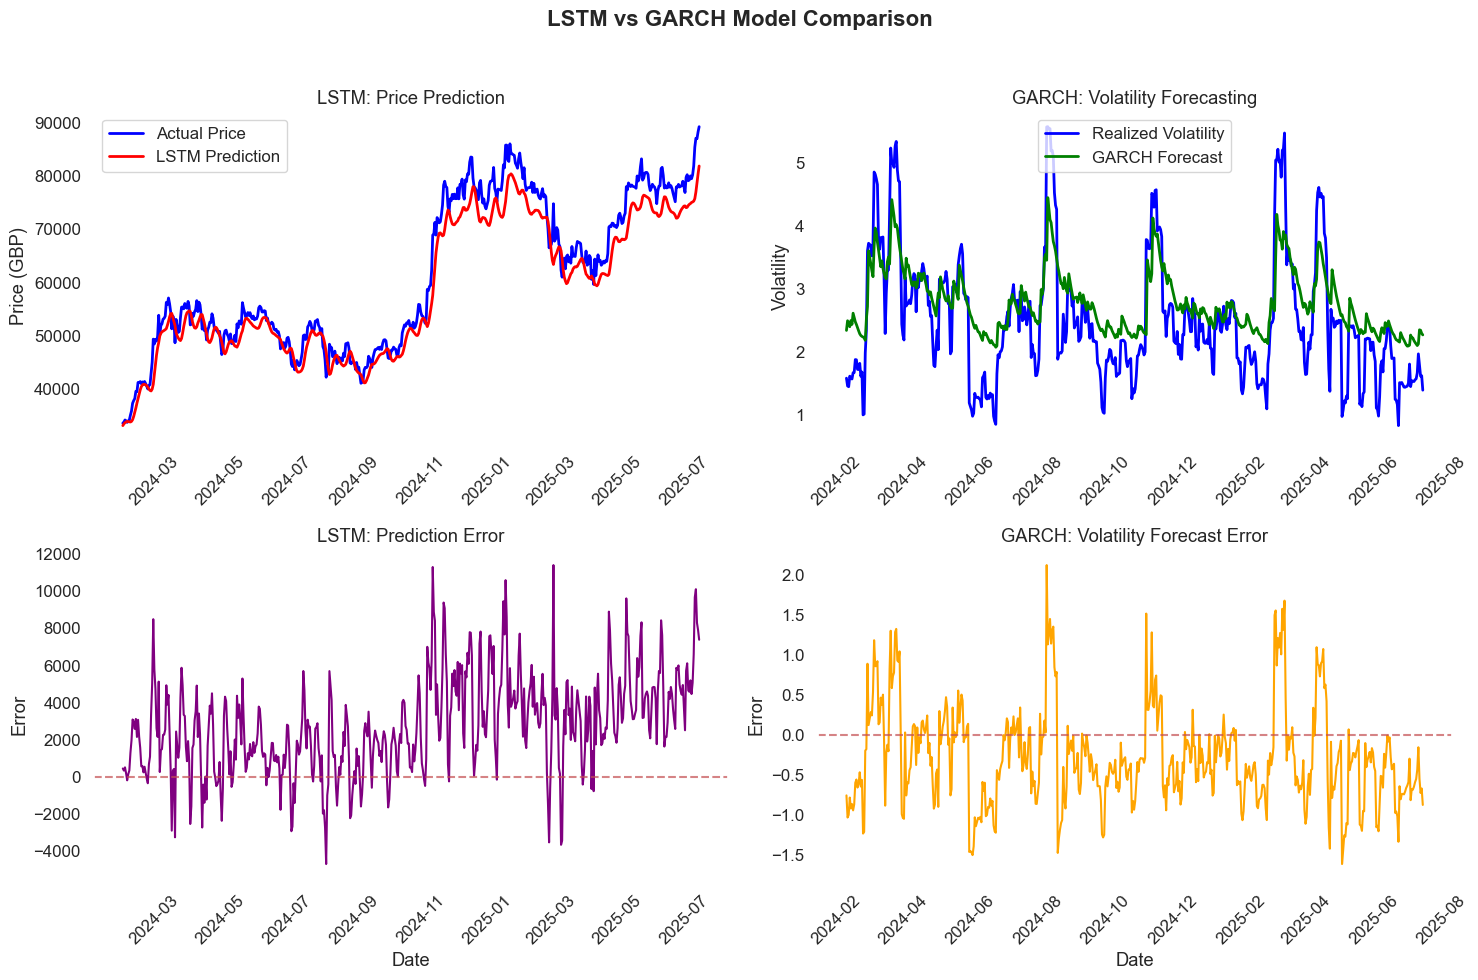

In [22]:
def compare_models(merged_data, sequence_length = 60, train_split = 0.7, epochs = 25, batch_size = 32):
    """
    Compare LSTM and GARCH models for Bitcoin price forecasting.
    """
    # Preparing data for both models
    # For LSTM
    price_data = merged_data[['Close']].values
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(price_data)
    
    # Creating sequences for LSTM
    def create_sequences(data, seq_length):
        x = []
        y = []
        for i in range(seq_length, len(data)):
            x.append(data[i - seq_length:i])
            y.append(data[i])
        return np.array(x), np.array(y)
    
    x, y = create_sequences(scaled_data, sequence_length)
    split_index = int(len(x) * train_split)
    x_test = x[split_index:]
    y_test = y[split_index:]
    test_dates = merged_data.index[split_index + sequence_length:]
    
    # For GARCH
    btc_data = merged_data[['Close']].copy()
    btc_data['Returns'] = btc_data['Close'].pct_change() * 100
    btc_data.dropna(inplace=True)
    
    # Fitting GARCH model
    garch_model = arch_model(btc_data['Returns'], vol='Garch', p=1, q=1)
    garch_results = garch_model.fit(disp='off')
    
    # Making predictions with LSTM
    lstm_predictions = model.predict(x_test)
    lstm_predictions = scaler.inverse_transform(lstm_predictions)
    actual_prices = scaler.inverse_transform(y_test)
    
    # Calculating metrics for LSTM
    lstm_mse = mean_squared_error(actual_prices, lstm_predictions)
    lstm_rmse = np.sqrt(lstm_mse)
    lstm_mae = mean_absolute_error(actual_prices, lstm_predictions)
    lstm_r2 = r2_score(actual_prices, lstm_predictions)
    
    # For GARCH, volatility forecasts will be used
    # to get the last part of conditional volatility for the test period
    garch_volatility = garch_results.conditional_volatility[-len(test_dates):]
    
    # Calculate realized volatility i.e. standard deviation of returns
    returns_test = btc_data['Returns'][-len(test_dates):]
    realized_volatility = returns_test.rolling(window=10).std().dropna()
    
    # set dates
    aligned_dates = realized_volatility.index
    garch_volatility_aligned = garch_volatility[-len(aligned_dates):]
    
    # Calculate metrics for GARCH volatility forecasting
    garch_mse = mean_squared_error(realized_volatility, garch_volatility_aligned)
    garch_rmse = np.sqrt(garch_mse)
    garch_mae = mean_absolute_error(realized_volatility, garch_volatility_aligned)
    
    # Print comparison
    print("="*50)
    print("MODEL COMPARISON: LSTM vs GARCH")
    print("="*50)
    print("\nLSTM PRICE PREDICTION PERFORMANCE:")
    print(f"MSE: {lstm_mse:.4f}")
    print(f"RMSE: {lstm_rmse:.4f}")
    print(f"MAE: {lstm_mae:.4f}")
    print(f"R²: {lstm_r2:.4f}")
    
    print("\nGARCH VOLATILITY FORECASTING PERFORMANCE:")
    print(f"MSE: {garch_mse:.4f}")
    print(f"RMSE: {garch_rmse:.4f}")
    print(f"MAE: {garch_mae:.4f}")
    
    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize = (15, 10))
    fig.suptitle('LSTM vs GARCH Model Comparison', fontsize = 16, fontweight = 'bold')
    
    # Plot 1: LSTM Price Predictions
    axes[0, 0].plot(test_dates, actual_prices, label= 'Actual Price', color = 'blue', linewidth = 2)
    axes[0, 0].plot(test_dates, lstm_predictions, label= 'LSTM Prediction', color = 'red', linewidth = 2)
    axes[0, 0].set_title('LSTM: Price Prediction')
    axes[0, 0].set_ylabel('Price (GBP)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: GARCH Volatility Forecasting
    axes[0, 1].plot(aligned_dates, realized_volatility, label = 'Realized Volatility', color = 'blue', linewidth = 2)
    axes[0, 1].plot(aligned_dates, garch_volatility_aligned, label = 'GARCH Forecast', color = 'green', linewidth = 2)
    axes[0, 1].set_title('GARCH: Volatility Forecasting')
    axes[0, 1].set_ylabel('Volatility')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha = 0.3)
    
    # Plot 3: LSTM Prediction Error
    lstm_error = actual_prices.flatten() - lstm_predictions.flatten()
    axes[1, 0].plot(test_dates, lstm_error, color = 'purple', linewidth = 1.5)
    axes[1, 0].axhline(y = 0, color = 'r', linestyle = '--', alpha = 0.7)
    axes[1, 0].set_title('LSTM: Prediction Error')
    axes[1, 0].set_ylabel('Error')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].grid(True, alpha = 0.3)
    
    # Plot 4: GARCH Volatility Error
    garch_error = realized_volatility.values - garch_volatility_aligned
    axes[1, 1].plot(aligned_dates, garch_error, color = 'orange', linewidth = 1.5)
    axes[1, 1].axhline(y = 0, color = 'r', linestyle='--', alpha = 0.7)
    axes[1, 1].set_title('GARCH: Volatility Forecast Error')
    axes[1, 1].set_ylabel('Error')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].grid(True, alpha= 0.3)
    
    # Format dates on x-axis
    for ax in axes.flat:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)
    
    plt.tight_layout(rect = [0, 0, 1, 0.96]) 
    plt.show()
    
    return {
        'lstm_metrics': {'MSE': lstm_mse, 'RMSE': lstm_rmse, 'MAE': lstm_mae, 'R2': lstm_r2},
        'garch_metrics': {'MSE': garch_mse, 'RMSE': garch_rmse, 'MAE': garch_mae}
    }

# final comparison
comparison_results = compare_models(merged_data)